In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

import py4DSTEM
from py4DSTEM.process.braggdiskdetection import find_Bragg_disks, find_Bragg_disks_selected

In [4]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
dc = browser.get_dataobject('datacube_0')
diffslice = browser.get_dataobject('diffractionslice_0')
probe_kernel = diffslice.data['probe_kernel']

browser.close()

#### A few DPs

In [5]:
ave_im = np.average(dc.data,axis=(2,3))

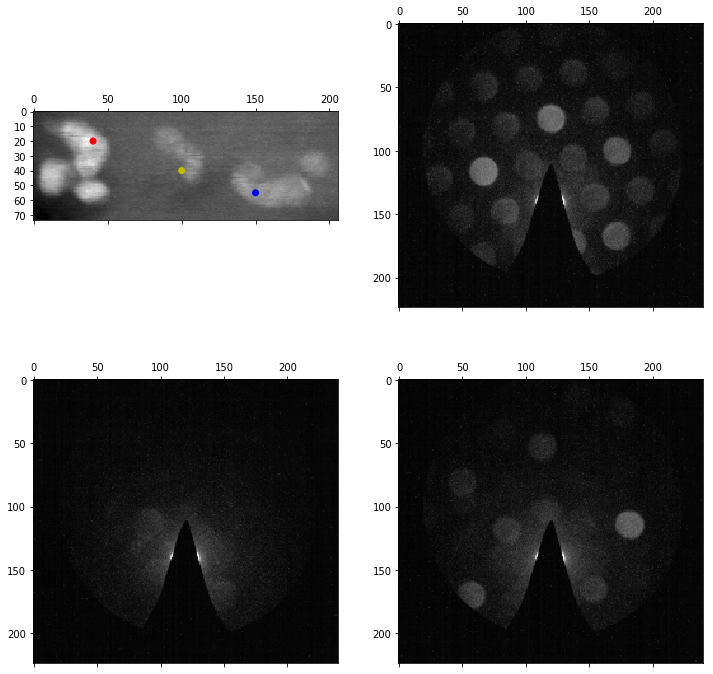

In [6]:
rx=(20,40,55)
ry=(40,100,150)
power = 0.05

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(12,12))
ax11.matshow(ave_im)
ax11.scatter(ry,rx, color=('r','y','b'))
ax12.matshow(dc.data[rx[0],ry[0],:,:]**power)
ax21.matshow(dc.data[rx[1],ry[1],:,:]**power)
ax22.matshow(dc.data[rx[2],ry[2],:,:]**power)
plt.show()

In [19]:
# Get peaks

corrPower = .9
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 30
minRelativeIntensity = 0.01

peaks = find_Bragg_disks_selected(dc, probe_kernel, rx, ry,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks)

Analyzed 3 diffraction patterns in 0h 0m 0s


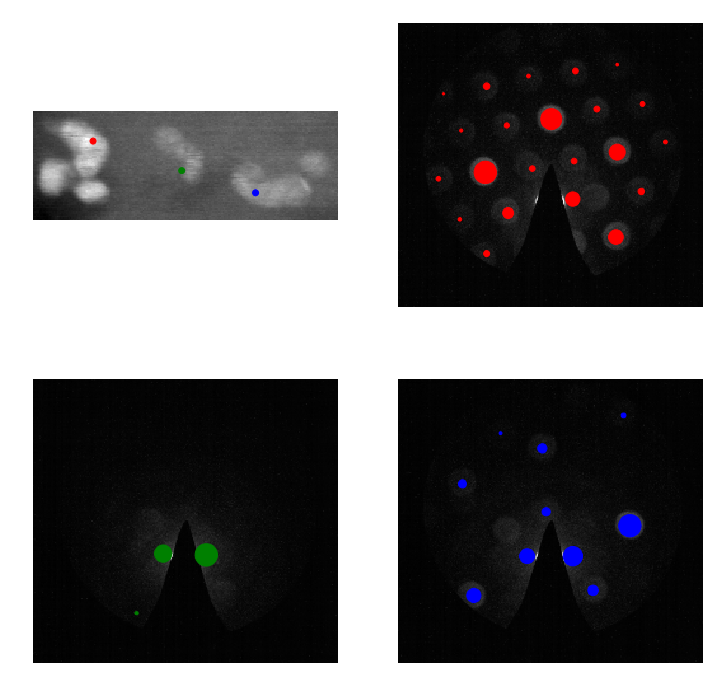

In [20]:
# Show

power=0.3
size_scale_factor = 500       # Set to zero to make all points the same size

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(ave_im)
ax11.scatter(ry,rx,color=('r','g','b'))
ax12.matshow(dc.data[rx[0],ry[0],:,:]**power)
ax21.matshow(dc.data[rx[1],ry[1],:,:]**power)
ax22.matshow(dc.data[rx[2],ry[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))


ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

#### All DPs

In [21]:
peaks = find_Bragg_disks(dc, probe_kernel,
                         corrPower=corrPower,
                         sigma=sigma,
                         edgeBoundary=edgeBoundary,
                         minRelativeIntensity=minRelativeIntensity,
                         minPeakSpacing=minPeakSpacing,
                         maxNumPeaks=maxNumPeaks,
                         verbose=True)

Analyzed 15244 diffraction patterns in 0h 2m 38s


#### Get deconvolution

In [23]:
deconvolution = py4DSTEM.file.datastructure.DiffractionSlice(data=np.zeros((dc.Q_Nx,dc.Q_Ny)), name='deconvolution')

for Rx in range(peaks.shape[0]):
    for Ry in range(peaks.shape[1]):
        pointlist = peaks.get_pointlist(Rx,Ry)
        for k in range(pointlist.length):
            qx = int(pointlist.data['qx'][k])
            qy = int(pointlist.data['qy'][k])
            if (qx<dc.Q_Nx) and (qy<dc.Q_Ny):
                deconvolution.data[qx,qy] += pointlist.data['intensity'][k]

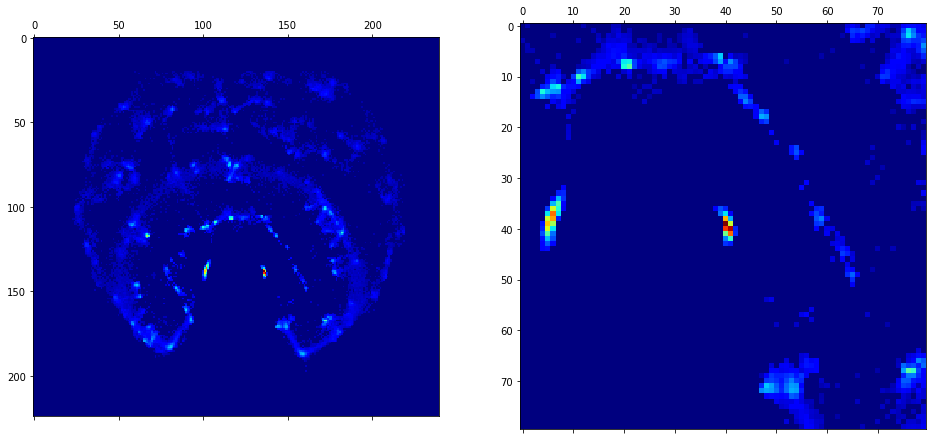

In [27]:
# Plot

x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution.data,3)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution.data**0.25,cmap='jet')
ax2.matshow(deconvolution.data[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

#### Remove Bragg peaks from counts on/at beam stop

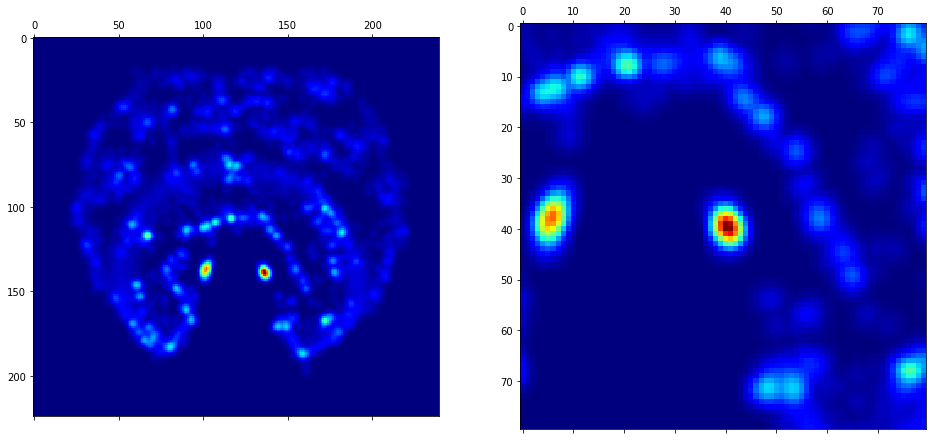

In [29]:
sigma=1

deconvolution_smoothed = gaussian_filter(deconvolution.data,sigma)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution_smoothed**0.25,cmap='jet')
ax2.matshow(deconvolution_smoothed[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [33]:
# Get maxima

maxima = py4DSTEM.process.utils.get_maximal_points(deconvolution_smoothed)
max_point_indices_x, max_point_indices_y = np.nonzero(maxima)
point_intensities = deconvolution_smoothed[max_point_indices_x,max_point_indices_y]

coords = [('qx',float),('qy',float),('intensity',float)]
deconvolution_peaks = py4DSTEM.file.datastructure.PointList(coordinates=coords)
length = len(point_intensities)
for i in range(length):
    new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
    deconvolution_peaks.add_point(new_point)

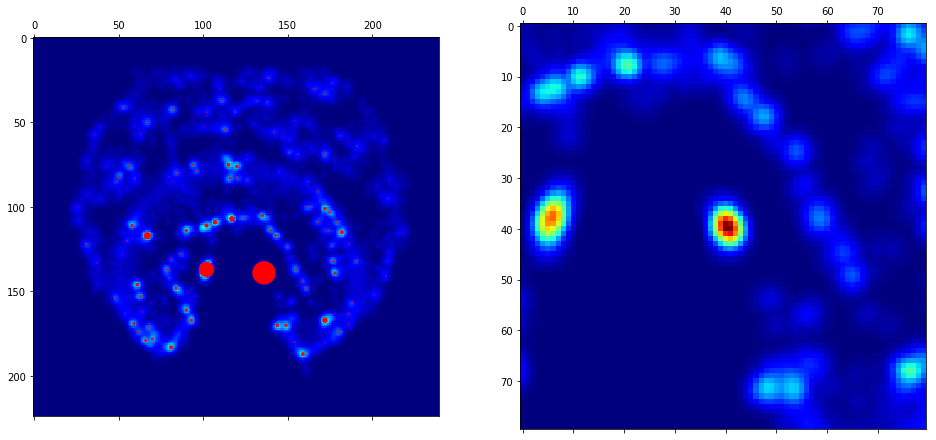

In [37]:
scale=500

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution_smoothed**0.25,cmap='jet')
ax1.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r',
            s=scale*deconvolution_peaks.data['intensity']/np.max(deconvolution_peaks.data['intensity']))
ax2.matshow(deconvolution_smoothed[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [54]:
remove_radius = 10

deconvolution_peaks.sort('intensity')
x0,y0 = deconvolution_peaks.data['qx'][0],deconvolution_peaks.data['qy'][0]
x1,y1 = deconvolution_peaks.data['qx'][1],deconvolution_peaks.data['qy'][1]

for Rx in range(peaks.shape[0]):
    for Ry in range(peaks.shape[1]):
        pointlist = peaks.get_pointlist(Rx,Ry)
        
        r0 = np.hypot(pointlist.data['qx']-x0, pointlist.data['qy']-y0)
        r1 = np.hypot(pointlist.data['qx']-x1, pointlist.data['qy']-y1)
        
        deletemask = np.logical_or((r0 <= remove_radius),(r1 < remove_radius))
        pointlist.remove_points(deletemask)

In [55]:
# Recalculate deconvolution

deconvolution = py4DSTEM.file.datastructure.DiffractionSlice(data=np.zeros((dc.Q_Nx,dc.Q_Ny)), name='deconvolution')

for Rx in range(peaks.shape[0]):
    for Ry in range(peaks.shape[1]):
        pointlist = peaks.get_pointlist(Rx,Ry)
        for k in range(pointlist.length):
            qx = int(pointlist.data['qx'][k])
            qy = int(pointlist.data['qy'][k])
            if (qx<dc.Q_Nx) and (qy<dc.Q_Ny):
                deconvolution.data[qx,qy] += pointlist.data['intensity'][k]

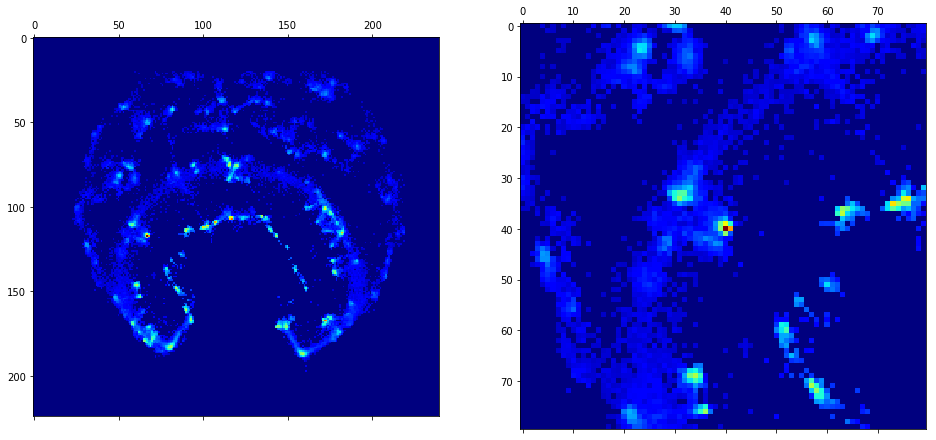

In [56]:
# Plot

x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution.data,3)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution.data**0.25,cmap='jet')
ax2.matshow(deconvolution.data[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

#### Save

In [63]:
peaks.name = 'Bragg_peaks'
average_image = py4DSTEM.file.datastructure.RealSlice(data=ave_im, name='average_image')

In [62]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
py4DSTEM.file.io.append([deconvolution, peaks, average_image],fp)

Opening file /home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5...
Done.
